In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from scipy.stats import norm
from scipy import stats 

In [4]:
train = pd.read_csv('../data/train.csv')
weather = pd.read_csv('../data/weather.csv')
key = pd.read_csv('../data/key.csv')
test = pd.read_csv('../data/test.csv')
sample = pd.read_csv('../data/sampleSubmission.csv')

In [22]:
weather.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,,0.0,0.00,29.95,30.47,14.0,36,13.8


In [5]:
def match_dateformat(df, year):
    """
    영문 월을 숫자 월로 바꾸어주고 나중에 사용하기 쉽도록 datetime.date 형태로 바꾸어주는 함수
    """
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i in range(len(df)):
        dates = df.loc[i][0]
        dates = dates.split(" ")
        for j in range(len(months)):
            if dates[0] == months[j]:
                dates[0] = str(j + 1)
                dates_df = ["{} {} {}".format(year, dates[0], dates[1])]
                dates_df = pd.to_datetime(dates_df)
                df.loc[i][0] = dates_df.date[0]
    return df

In [6]:
def merge_holiday(holiday_df1, holiday_df2, holiday_df3):
    """
    각 연도별 공휴일 리스트 합치기
    """
    frame = [holiday_df1, holiday_df2, holiday_df3]
    holiday = pd.concat(frame).reset_index(drop=True)
    return holiday

In [7]:
def find_holiday(file, year):
    """
    수요에 영향을 미치는 주요 공휴일을 찾아내는 함수
    """
    holidays = ["New Year's Day", "Martin Luther King Jr. Day", "Valentine's Day",  "President's Day", "Easter Sunday", 
                      "Mother's Day", "Memorial Day", "Father's Day", "Independence Day", "Labor Day", "Columbus Day",
                      "Halloween", "Veterans Day", "Thanksgiving Day", "Black Friday", "Christmas Eve", "Christmas Day", "New Year's Eve"]
    
    holi = pd.read_excel(file, year, header=None)
    holi = match_dateformat(holi, year)
    holiday = pd.DataFrame(columns=[0,1,2,3,4])
    for _ in holidays:
        for i in range(len(holi[2])):
            if _ == holi[2][i]:
                holiday = holiday.append(holi.loc[i])
    return holiday

In [8]:
def preprocessing(df, holiday):
    """
    train데이터를 가공하는 함수
    """
    df['log_unit'] = np.log(df['units'] + 1)
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df.date.dt.weekday #월요일이 0 일요일이 6
    df['weekend'] = df.date.dt.weekday.isin([5, 6]) # 5: 토요일, 6: 일요일
    
    df['holiday'] = df.date.isin(holiday[0])
    df['weekday_holiday'] = df.holiday & (df.weekend == False)
    df['weekend_holiday'] = df.holiday & df.weekend
    return df

In [27]:
%whos

Variable           Type         Data/Info
-----------------------------------------
find_holiday       function     <function find_holiday at 0x000000F9108F5EA0>
key                DataFrame        store_nbr  station_nb<...>4         45           16
match_dateformat   function     <function match_dateformat at 0x000000F90010CB70>
matplotlib         module       <module 'matplotlib' from<...>matplotlib\\__init__.py'>
merge_holiday      function     <function merge_holiday at 0x000000F9108F5730>
norm               norm_gen     <scipy.stats._continuous_<...>ct at 0x000000F964D47F28>
np                 module       <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
pd                 module       <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
plt                module       <module 'matplotlib' from<...>matplotlib\\__init__.py'>
preprocessing      function     <function preprocessing at 0x000000F967168730>
sample             DataFrame                           id<...>[526917 

In [9]:
train_new = train[:2255853]

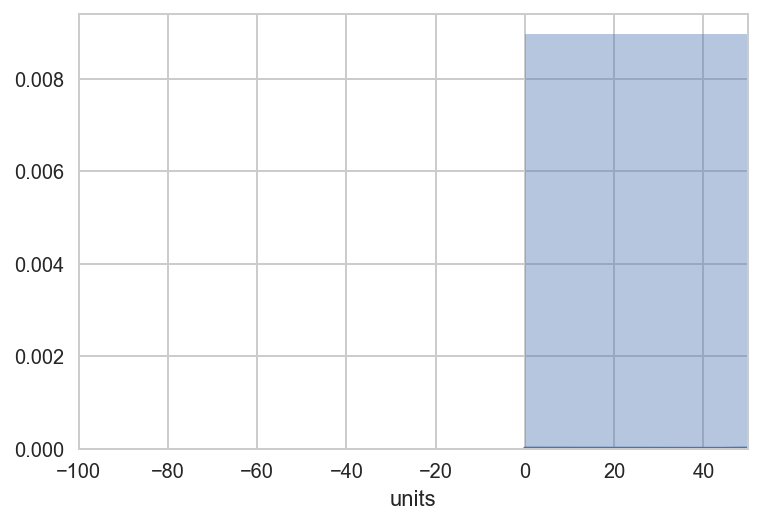

In [10]:
sns.distplot(train_new['units'])
plt.xlim(-100, 50)
plt.show()

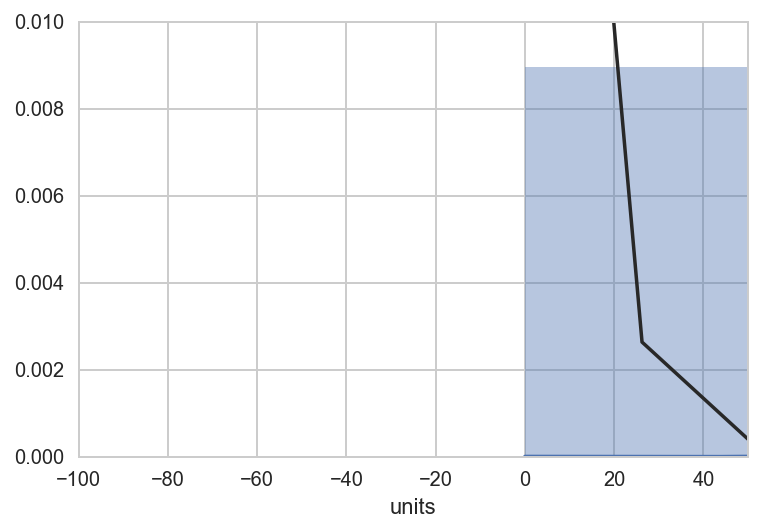

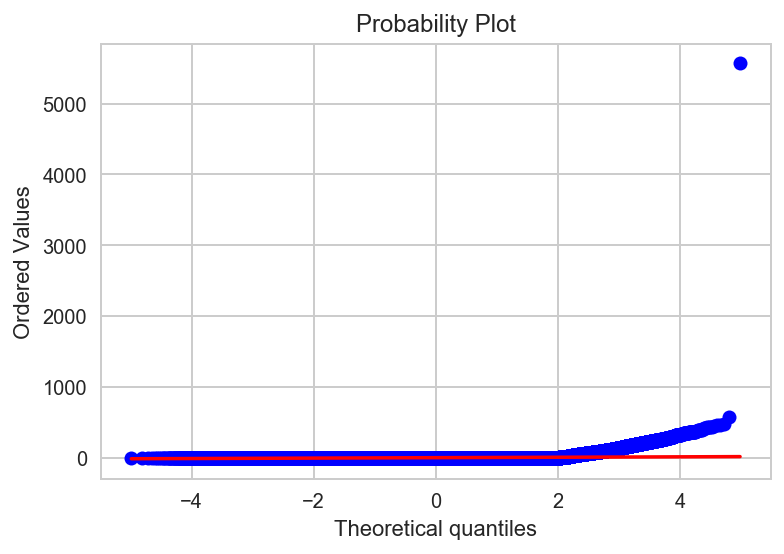

In [11]:
#histogram and normal probability plot
plt.xlim(-100,50)
plt.ylim(0, 0.01)
sns.distplot(train_new['units'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_new['units'], plot=plt)

In [12]:
#applying log transformation
train['units'] = np.log(train['units'] + 1)

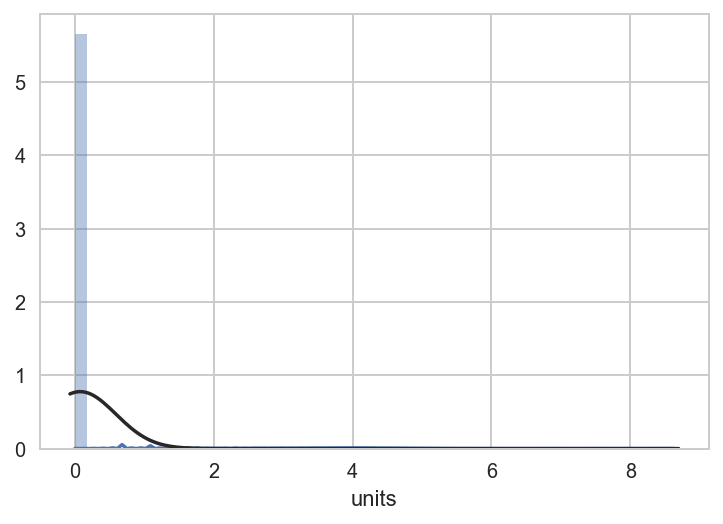

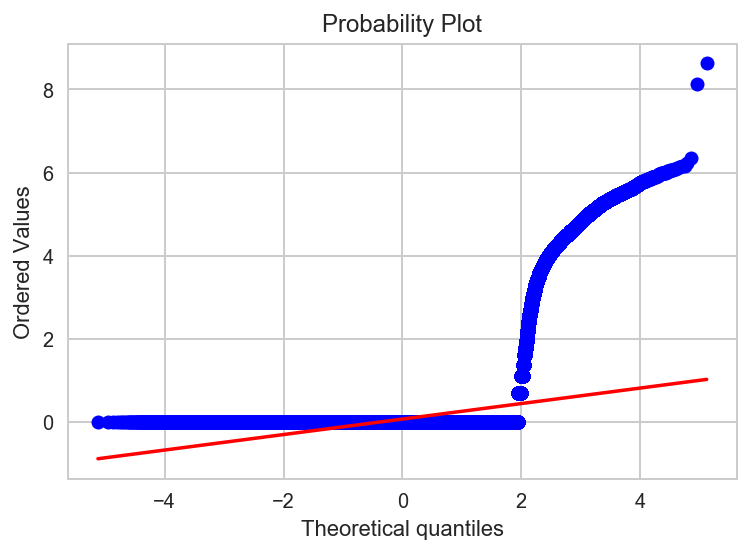

In [13]:
#transformed histogram and normal probability plot
sns.distplot(train['units'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['units'], plot=plt)

In [ ]:
holiday12 = find_holiday('holiday.xlsx', '2012')
holiday13 = find_holiday('holiday.xlsx', '2013')
holiday14 = find_holiday('holiday.xlsx', '2014')
holiday = merge_holiday(holiday12, holiday13, holiday14)
train = train.merge(key, left_on='store_nbr', right_on='store_nbr')
processed_train = preprocessing(train, holiday)
train_pivot = train.pivot_table(values='units', index=['date'], columns=['station_nbr','store_nbr','item_nbr'], aggfunc=np.sum)

In [ ]:
processed_train.tail()

In [ ]:
train_pivot.tail()